In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Factor Analysis

## Data simulation

In [2]:
def GaussDataSimul(N, d, T):
    Atrue = np.random.uniform(0,1, (N,d))                   # true loading factors
    Rtrue = np.diag((np.arange(N)+1)/N)                     # true unique noise 

    z = np.random.normal(0, 1, (d, T))                      # prior
    w = np.sqrt(Rtrue) @ np.random.normal(0,1,(N,T))        # noise
    X = Atrue @ z + w;                                      # observations
    return X, z, Rtrue

In [3]:
N = 50;                                 # observation space dimensions
d = 3;                                  # latent space dimensions
T = 1000;                               # number of observations
X, z_real, R_true = GaussDataSimul(N, d, T);    # Noisy observations

## Data statistics

In [4]:
X_mu = np.mean(X, axis=1);              # data mean
X_cov = np.cov(X)                       # data covariance
xDim = len(X_mu);                       # observation space dimensions

## FA - EM

In [5]:
def FA_EM(X_cov, xDim, zDim, eps, T, penalty=2.5):
    A = abs(np.random.uniform(0,1, (xDim,zDim))/np.sqrt(zDim))  # initiate A
    R = np.diag(np.diag(X_cov))                                 # initiate R

    # eps = 1e-7                                                # define stopping value
    LL_prev = 0                                                 # initiate LL reference
    LL_step = eps+1                                             # non-stop value for while loop
    LL_cache = []                                               # array with LL values
    counter = 0 
    while LL_step > eps:                                        # EM FA
        # E-step
        delta = np.linalg.pinv(A @ A.T + R)
        beta = A.T @ delta

        # M-step
        A = (X_cov @ beta.T @ 
             np.linalg.pinv(np.identity(zDim) - beta @ A + beta @ X_cov @ beta.T))
        R = np.diag(np.diag(X_cov - A @ beta @ X_cov))

        # avg. LL
        LL = -T/2*np.trace(delta @ X_cov) + T/2*np.linalg.slogdet(delta)[1] - T*xDim/2*np.log(2*np.pi) 
                                                                # N*sum(log(diag(chol(MM))))
        LL_step = abs((LL-LL_prev)/abs(LL))
        LL_prev = LL
        LL_cache.append(LL)
        counter += 1
        if counter > 1e4:
            break

    LL_corrected = LL - zDim ** penalty

    return A, R, LL_cache, LL_corrected

In [6]:
zDims = np.arange(29)+2                 # latent space dimensions
eps = 1e-7                              # define stopping value
LL_dim = []                             # max LL per dim

In [7]:
A = []
R = []
LL_cache = []
LL_corrected = []

for zDim in zDims:
    tA, tR, tLL_cache, tLL_corrected = FA_EM(X_cov, xDim, zDim, eps, T)
    A.append(tA)
    R.append(tR)
    LL_cache.append(tLL_cache)
    LL_corrected.append(tLL_corrected)

## Reconstruct latent data

In [8]:
rzDim = np.argmax(LL_corrected)
Re = R[rzDim]
Ae = A[rzDim]
z = Ae.T @ np.linalg.pinv(Ae @ Ae.T + Re) @ (X - np.tile(X_mu, (X.shape[1], 1)).T)
print('Number of latent dimensions: '+str(rzDim))

Number of latent dimensions: 3


## Plotting results

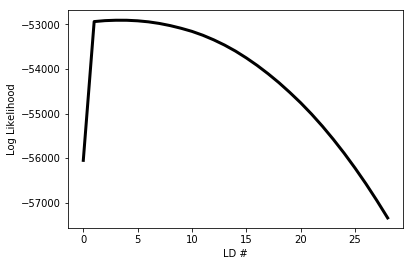

In [9]:
LLDim_plot = plt.plot(LL_corrected, c='k', lw=3)
LLDim_plot = plt.xlabel('LD #')
LLDim_plot = plt.ylabel('Log Likelihood')

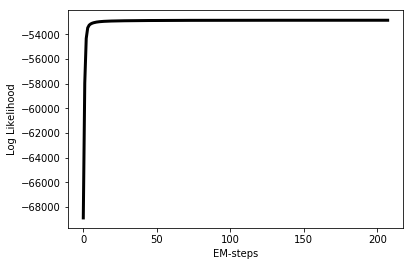

In [10]:
LL_plot = plt.plot(LL_cache[rzDim], c='k', lw=3)
LL_plot = plt.xlabel('EM-steps')
LL_plot = plt.ylabel('Log Likelihood')

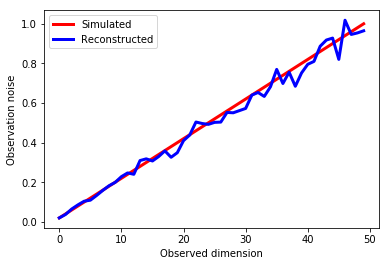

In [11]:
R_plot = plt.plot(np.arange(len(R_true)), np.diag(R_true), c='r', lw=3)
R_plot = plt.plot(np.arange(len(R[rzDim])), np.diag(R[rzDim]), c='b', lw=3)
R_plot = plt.xlabel('Observed dimension')
R_plot = plt.ylabel('Observation noise')
R_plot = plt.legend(('Simulated', 'Reconstructed'))

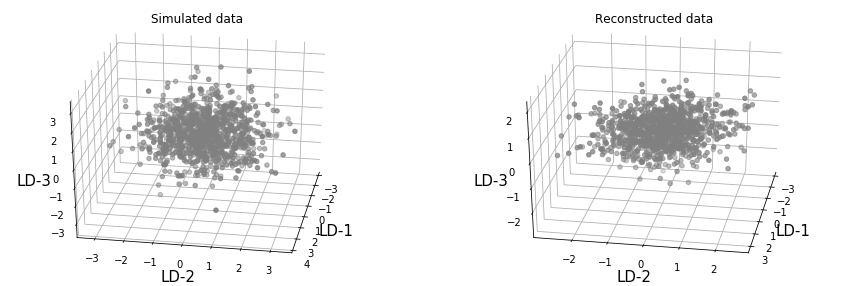

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(z_real[0, :], z_real[1, :], z_real[2, :], c='grey')

plt.title('Simulated data')
ax.set_xlabel('LD-1', fontsize=15)
ax.set_ylabel('LD-2', fontsize=15)
ax.set_zlabel('LD-3', fontsize=15)
ax.view_init(30, 10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(z[0, :], z[1, :], z[2, :], c='grey')

plt.title('Reconstructed data')
ax.set_xlabel('LD-1', fontsize=15)
ax.set_ylabel('LD-2', fontsize=15)
ax.set_zlabel('LD-3', fontsize=15)
ax.view_init(30, 10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')